In [1]:
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator

In [3]:
#clusters = pd.read_json("./files/cluster.json")

In [4]:
def plotSteps(data):
    for runIdx in range(0, len(data)):
        fig, ax = plt.subplots()
        iteration = data.iloc[runIdx]["iteration"]
        clusters = data.iloc[runIdx]["clusters"]
        norm = colors.Normalize(vmin=0, vmax=len(clusters))
        print("iteration: %s, clusters: %s" % (iteration, len(clusters)))
        for cIdx in range(0, len(clusters)):
            rgba_color = cm.gnuplot(norm(cIdx))
            pointsX = [point[0] for point in clusters[cIdx]["points"]]
            pointsY = [point[1] for point in clusters[cIdx]["points"]]
            ax.scatter(pointsX, pointsY, color=rgba_color)
            ax.scatter(clusters[cIdx]["centroid"][0], clusters[cIdx]["centroid"][1], color=rgba_color, marker="+")

        plt.show()

In [5]:
plotSteps(clusters)

NameError: name 'clusters' is not defined

In [6]:
def plot(data):
    for runIdx in range(0, len(data)):
        fig, ax = plt.subplots()
        clusters_step1 = data.iloc[runIdx]["steps"][0]["clusters"]
        clusters_step2 = data.iloc[runIdx]["steps"][1]["clusters"]
        norm = colors.Normalize(vmin=0, vmax=len(clusters_step1))
        for cIdx in range(0, len(clusters_step1)):
            rgba_color = cm.gnuplot(norm(cIdx))
            ax.plot(clusters_step1[cIdx]["syntheticCenter"], "--", color=rgba_color, label="cluster %s" % cIdx)
            ax.plot(clusters_step2[cIdx]["syntheticCenter"], color=rgba_color, label="cluster %s - rescheduled" % cIdx)
            print(clusters_step2[cIdx]["metric"])
        ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)

        ax.set(xlabel='Hours', ylabel='Power (kW)',title='')
        plt.show()

In [7]:
def plot_aggm(summary, file_name=None): 
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. agg m"], "--", color=rgba_color, label="s1. agg m")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. agg m"], color=rgba_color, label="s2. agg m")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Aggregate PAR',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig
    
def plot_maxm(summary, file_name=None): 
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. max m"], "--", color=rgba_color, label="s1. max m")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. max m"], color=rgba_color, label="s2. max m")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Max. Aggregate PAR',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig
    
def plot_peak(summary, file_name=None):
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. peak"], "--", color=rgba_color, label="s1. peak")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. peak"], color=rgba_color, label="s2. peak")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Peak power (kW)',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig

# PAR Aggregate

In [62]:
summaryBatch_global = pd.read_json("./files/scheduler_tests/scheduler_test/summaryBatch.json")
#summaryBatch_global = summaryBatch_global[["k","clusters","s1. agg m","s1. max m","s1. peak","s2. agg m","s2. max m","s2. peak","total m"]]
#batch_global = pd.read_json("./files/batch.json")

k = 3
sampleSizeMin = 1.0
sampleSizeMax = 1.0
nSteps = 2


def sampleSizeRange():
    return (x/10 for x in range(int(sampleSizeMin * 10), int((sampleSizeMax * 10) + 1)))

In [76]:
index_list = []
step_list = []

for i in range(0 , len(summaryBatch_global)):
    register = summaryBatch_global.iloc[i]
    
    crossfold = json_normalize(register["crossfold"])
    splits = crossfold["splits"].values[0]
    steps = summaryBatch_global.iloc[i]["step"]
    for j in range(0, splits):
        step = json_normalize(steps[j])
        for ki in range(1, k+1):
            index_list.append((float("{0:.2f}".format(crossfold["sampleSize"].values[0])), j, ki))
            step_list.append(step.iloc[ki-1])
        
    
json_normalize(summaryBatch_global.iloc[0]["crossfold"])
json_normalize(summaryBatch_global.iloc[0]["step"][0])

index = pd.MultiIndex.from_tuples(index_list, names=["sampleSize", "split", "k"])
summaryBatch_global_treated = pd.DataFrame(step_list, index=index)
summaryBatch_global_treated

k  s1. peak  s1. agg m  s1. max m  s1. total m  \
sampleSize split k                                                   
1.0        0     1  1   1244625   1.962355   1.962355     1.962355   
                 2  2    628946   1.004935   1.972190     1.962355   
                 3  3    461762   1.030594   2.020031     1.962355   

                        clusters  s2. peak  s2. agg m  s2. max m  s2. total m  
sampleSize split k                                                             
1.0        0     1          [51]   1167909   1.841400   1.841400       1.8414  
                 2      [28, 23]    590309   1.024874   1.890923       1.8414  
                 3  [19, 14, 18]    412265   1.022921   1.886465       1.8414

In [64]:
k2 = 2
query = f"k == {k2} and sampleSize == {sampleSizeMin}"
summaryBatch_global_treated.query(query)["s1. agg m"].mean()
summaryBatch_global_treated.query(query)["s1. max m"].mean()
summaryBatch_global_treated.query(query)["s1. peak"].std()

nan

In [65]:
with open('summaryBatch.tex','w') as tf:
    tf.write(summaryBatch_global.to_latex())

In [79]:
index_list = []
step_list = []

for j in range(1, k+1):
    for ssize in sampleSizeRange():
        
        index_list.append((ssize, "mean", j))
        query = f"k == {j} and sampleSize == {ssize}"
        data = {"s1. agg m" : summaryBatch_global_treated.query(query)["s1. agg m"].mean(),
                "s1. max m" : summaryBatch_global_treated.query(query)["s1. max m"].mean(), 
                "s1. peak" : summaryBatch_global_treated.query(query)["s1. peak"].mean(),
               "s1. total m" : summaryBatch_global_treated.query(query)["s1. total m"].mean()}
        index = ["s1. agg m","s1. max m","s1. peak", "s1. total m"]
        if (nSteps >= 2):
            data.update({"s2. agg m" : summaryBatch_global_treated.query(query)["s2. agg m"].mean(),
                "s2. max m" : summaryBatch_global_treated.query(query)["s2. max m"].mean(), 
                "s2. peak" : summaryBatch_global_treated.query(query)["s2. peak"].mean(),
                        "s2. total m" : summaryBatch_global_treated.query(query)["s2. total m"].mean()})
            index = index + ["s2. agg m","s2. max m","s2. peak", "s2. total m"]
            
        s = pd.Series(data,index=index) 
        step_list.append(s)
        #print(f"sampleSize = {ssize}, k = {j}")
        
        index_list.append((ssize, "stdv", j))
        query = f"k == {j} and sampleSize == {ssize}"
        data = {"s1. agg m" : summaryBatch_global_treated.query(query)["s1. agg m"].std(),
                "s1. max m" : summaryBatch_global_treated.query(query)["s1. max m"].std(), 
                "s1. peak" : summaryBatch_global_treated.query(query)["s1. peak"].std(),
               "s1. total m" : summaryBatch_global_treated.query(query)["s1. total m"].std()}
        index = ["s1. agg m","s1. max m","s1. peak", "s1. total m"]
        if (nSteps >= 2):
            data.update({"s2. agg m" : summaryBatch_global_treated.query(query)["s2. agg m"].std(),
                "s2. max m" : summaryBatch_global_treated.query(query)["s2. max m"].std(), 
                "s2. peak" : summaryBatch_global_treated.query(query)["s2. peak"].std(),
                        "s2. total m" : summaryBatch_global_treated.query(query)["s2. total m"].std()})
            index = index + ["s2. agg m","s2. max m","s2. peak", "s2. total m"]
            
        s = pd.Series(data,index=index) 
        step_list.append(s)

        
index = pd.MultiIndex.from_tuples(index_list, names=["sampleSize", "metric", "k"])
summaryBatch_global_statistics = pd.DataFrame(step_list, index=index)
summaryBatch_global_statistics

s1. agg m  s1. max m   s1. peak  s1. total m  s2. agg m  \
sampleSize metric k                                                            
1.0        mean   1   1.962355   1.962355  1244625.0     1.962355   1.841400   
           stdv   1        NaN        NaN        NaN          NaN        NaN   
           mean   2   1.004935   1.972190   628946.0     1.962355   1.024874   
           stdv   2        NaN        NaN        NaN          NaN        NaN   
           mean   3   1.030594   2.020031   461762.0     1.962355   1.022921   
           stdv   3        NaN        NaN        NaN          NaN        NaN   

                     s2. max m   s2. peak  s2. total m  
sampleSize metric k                                     
1.0        mean   1   1.841400  1167909.0       1.8414  
           stdv   1        NaN        NaN          NaN  
           mean   2   1.890923   590309.0       1.8414  
           stdv   2        NaN        NaN          NaN  
           mean   3   1.886465   412265.0       1.8414  
           stdv   3        NaN        NaN          NaN

In [81]:
def getMetrics(metric, summaryMetric):

    index_list = [sampleSizeRange()]
    cols = [x for x in range(1, k+1)]
    step_list = []

    for ssize in sampleSizeRange():
        query = f"sampleSize == {ssize} and metric == \"{summaryMetric}\" "
        dataAllK = summaryBatch_global_statistics.query(query)[f"{metric}"]
        dictAllK = {}
        for j in range(1, k+1):
            d = dataAllK.reset_index().query(f"k == {j}")[f"{metric}"]
            dictAllK[f"{j}"] = d.values[0]
        s = pd.Series(dictAllK, name=f"{ssize}")
        step_list.append(s)

    return pd.DataFrame(step_list)
    
mname = "s1. max m"
mtype = "mean"
m = getMetrics(mname, mtype)

In [82]:
m

,1,2,3
1.0,1.962355,1.97219,2.020031


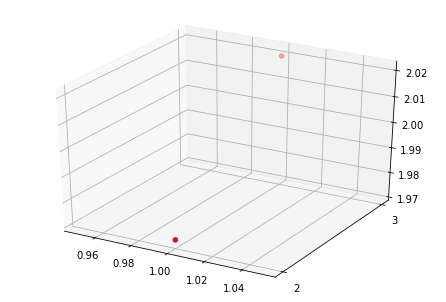

In [83]:
sampleSizes = []
kclusters = []
values = []
m2 = m.drop(columns=["1"])
for i in m2.index.values:
    for c in m2.columns.values:
        sampleSizes.append(float(i))
        kclusters.append(int(c))
        values.append(m2.loc[i:i, c:c].values[0][0])
        
fig = plt.figure()
ax = Axes3D(fig)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))


ax.scatter(sampleSizes, kclusters, values, marker='o', c="r")
plt.show()

KeyError: '6'

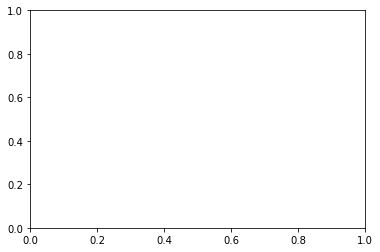

In [84]:
fig, ax = plt.subplots()

k2 = 6
sampleMaxMDataset = m2[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values = sampleMaxMDataset.values
ax.plot(sampleSizes, values, "-", label=f"K = {k2}", c="black")

k2 = 4
sampleMaxMDataset = m2[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values = sampleMaxMDataset.values
ax.plot(sampleSizes, values, "--", label=f"K = {k2}", c="black")

k2 = 2
sampleMaxMDataset = m2[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values = sampleMaxMDataset.values
ax.plot(sampleSizes, values, "-.", label=f"K = {k2}", c="black")

lgd = ax.legend(bbox_to_anchor=(1, -0.35), loc=4, borderaxespad=0.)
ax.set(xlabel='Sample Size %', ylabel='Max. Aggregate PAR',title='')
plt.show()
file_name = "peakpower_samplesize.pdf"
if file_name is not None:
    fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')


In [88]:
a = summaryBatch_global_statistics.query("sampleSize == 1.0 and metric == \"mean\"").reset_index().drop(["sampleSize", "metric"], axis=1)

In [89]:
_list = {}
for j in range(1, k+1):
    _list[j - 1] = str(summaryBatch_global_treated.query(f"sampleSize == 1.0 and k == {j}").sort_values(by=["s1. max m", "s1. agg m"]).iloc[0]["clusters"])
_list
b = pd.DataFrame.from_dict(_list, orient="index", columns=["clusters"])
r = pd.concat([a,b], axis=1, sort=False)
r = r[["k", "clusters", "s1. agg m", "s1. max m", "s1. peak", "s2. agg m", "s2. max m", "s2. peak"]]
r

,k,clusters,s1. agg m,s1. max m,s1. peak,s2. agg m,s2. max m,s2. peak
0,1,[51],1.962355,1.962355,1244625.0,1.841400,1.841400,1167909.0
1,2,"[28, 23]",1.004935,1.972190,628946.0,1.024874,1.890923,590309.0
2,3,"[19, 14, 18]",1.030594,2.020031,461762.0,1.022921,1.886465,412265.0


In [90]:
getMetrics("s1. agg m", "mean").iloc[-1]

1    1.962355
2    1.004935
3    1.030594
Name: 1.0, dtype: float64

In [91]:
with open('summaryBatch.tex','w') as tf:
    tf.write(r.to_latex())